# Preparing Package

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sweetviz as sv

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
import lightgbm as lgb

from imblearn.over_sampling import BorderlineSMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import optuna

import warnings
warnings.filterwarnings("ignore")

c:\Users\User\anaconda3\envs\miao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Data

In [2]:
# Training dataset
X = pd.read_csv(r'train_X.csv')
y = pd.read_csv(r'train_y.csv')

# Public testing dataset for upload to kaggle
X_test_public = pd.read_csv(r'test_X.csv')

print('Dataset for training and evaluating')
print('X_train shape:', X.shape)
print('y_train shape:', y.shape)
print()
print('Dataset for predict and upload on Kaggle')
print('X_test_public shape:', X_test_public.shape)

Dataset for training and evaluating
X_train shape: (44939, 83)
y_train shape: (44939, 1)

Dataset for predict and upload on Kaggle
X_test_public shape: (19260, 83)


---
---

# EDA

In [38]:
df = pd.concat([X, y], axis = 1)
print('Full data shape:', df.shape) # must be (44939, 84)
df.head()

Full data shape: (44939, 84)


,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,has_died
0,126956,125763,26,75.0,23.147277,0,Asian,M,163.0,Accident & Emergency,550,admit,Neuro ICU,0.128472,61.5,119.0,601.05,0,0.0,4.0,6.0,0.0,4.0,178.0,0.0,42.0,25.0,36.6,0.0,103.0,41.0,103.0,41.0,177.0,64.0,107.0,55.0,107.0,55.0,25.0,16.0,100.0,98.0,155.0,76.0,155.0,76.0,37.0,36.6,58.0,48.0,58.0,48.0,164.0,68.0,74.0,55.0,74.0,55.0,25.0,18.0,100.0,99.0,121.0,76.0,121.0,76.0,135.0,135.0,4.2,4.2,0.15,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0
1,18184,25399,54,42.0,35.071807,1,Caucasian,F,157.5,Operating Room / Recovery,479,admit,CTICU,3.150694,87.0,308.0,1207.01,1,0.0,2.0,4.0,0.0,1.0,130.0,0.0,50.0,43.0,35.9,1.0,136.0,16.0,NaN,NaN,126.0,70.0,184.0,55.0,NaN,NaN,40.0,14.0,100.0,87.0,232.0,75.0,NaN,NaN,39.0,35.9,50.0,30.0,NaN,NaN,119.0,109.0,87.0,66.0,NaN,NaN,16.0,16.0,100.0,100.0,134.0,105.0,NaN,NaN,336.0,84.0,4.6,2.9,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Undefined diagnoses,0
2,51597,7974,81,39.0,NaN,0,African American,M,182.9,Accident & Emergency,90,admit,Med-Surg ICU,0.006944,NaN,301.0,410.01,0,0.0,3.0,5.0,0.0,3.0,118.0,0.0,103.0,4.0,36.9,0.0,84.0,65.0,84.0,65.0,175.0,91.0,103.0,85.0,103.0,85.0,31.0,2.0,100.0,95.0,147.0,116.0,147.0,116.0,37.3,36.9,80.0,68.0,80.0,68.0,164.0,91.0,102.0,98.0,102.0,98.0,31.0,20.0,99.0,95.0,139.0,133.0,139.0,133.0,83.0,83.0,3.3,3.3,0.03,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
3,40078,79625,161,62.0,42.070672,0,Hispanic,F,157.0,Accident & Emergency,413,admit,Med-Surg ICU,0.084722,103.7,124.0,305.02,0,0.0,3.0,6.0,0.0,1.0,111.0,1.0,51.0,11.0,36.9,1.0,85.0,28.0,85.0,28.0,108.0,69.0,103.0,39.0,103.0,39.0,18.0,11.0,100.0,99.0,166.0,70.0,166.0,70.0,37.6,36.9,60.0,28.0,60.0,28.0,85.0,79.0,67.0,39.0,67.0,39.0,18.0,13.0,100.0,100.0,94.0,70.0,94.0,70.0,241.0,153.0,4.4,4.3,0.09,0.06,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
4,130673,88261,29,82.0,NaN,0,Caucasian,F,NaN,Accident & Emergency,904,admit,Med-Surg ICU,0.121528,NaN,119.0,601.03,0,0.0,3.0,6.0,0.0,5.0,117.0,0.0,58.0,31.0,NaN,0.0,65.0,44.0,65.0,44.0,122.0,80.0,79.0,58.0,79.0,58.0,31.0,13.0,100.0,81.0,140.0,90.0,140.0,90.0,38.3,37.4,52.0,52.0,52.0,52.0,103.0,87.0,61.0,61.0,61.0,61.0,21.0,15.0,95.0,81.0,90.0,90.0,90.0,90.0,167.0,167.0,5.0,5.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0


In [39]:
# Use auto EDA package for quick peering the full data pattern
EDA_report = sv.analyze(df, target_feat='has_died', )
EDA_report.show_html(filepath='EDA_REPORT_by_SWEETVIZ.html') 

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:12 -> (00:00 left)


Report EDA_REPORT_by_SWEETVIZ.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 通過 EDA 後有以下後續分類欄位的洞見
* numerical: `['age', 'bmi', 'height', 'weight', '_days', '_diagnosis', '_min', '_max', _death_prob]`
* cat: `['ethnicity', 'gender', 'icu_admit_source', '_type', '_bodysystem', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', '_diagnosis']`
* drop: `['encounter_id', 'patient_id']`
* not_sure = `['_apache']`

### 網路資料補充: 看似數值型但本質為類別資料:
* apache_2_diagnosis：這是與患者ICU（重症監護室）入院診斷相關的欄位，代表的是APACHE II（Acute Physiology and Chronic Health Evaluation II）評分系統中的診斷代碼。APACHE II是一種用於評估ICU患者病情嚴重程度的評分系統，包括生理參數和患者的臨床信息。
* apache_3j_diagnosis：這是APACHE III-J（Acute Physiology and Chronic Health Evaluation III-J）評分系統中的子診斷代碼，用於描述最能代表患者ICU入院原因的代碼。APACHE III是APACHE評分系統的升級版，也是一種用於評估ICU患者風險和預後的工具，其中的子診斷代碼提供了更詳細和精確的診斷信息。

## Check the '_apache' columns

In [40]:
_apache = [col for col in df.filter(like='_apache').columns]
df[_apache].head()

,arf_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,map_apache,resprate_apache,temp_apache,ventilated_apache
0,0.0,4.0,6.0,0.0,4.0,178.0,0.0,42.0,25.0,36.6,0.0
1,0.0,2.0,4.0,0.0,1.0,130.0,0.0,50.0,43.0,35.9,1.0
2,0.0,3.0,5.0,0.0,3.0,118.0,0.0,103.0,4.0,36.9,0.0
3,0.0,3.0,6.0,0.0,1.0,111.0,1.0,51.0,11.0,36.9,1.0
4,0.0,3.0,6.0,0.0,5.0,117.0,0.0,58.0,31.0,NaN,0.0


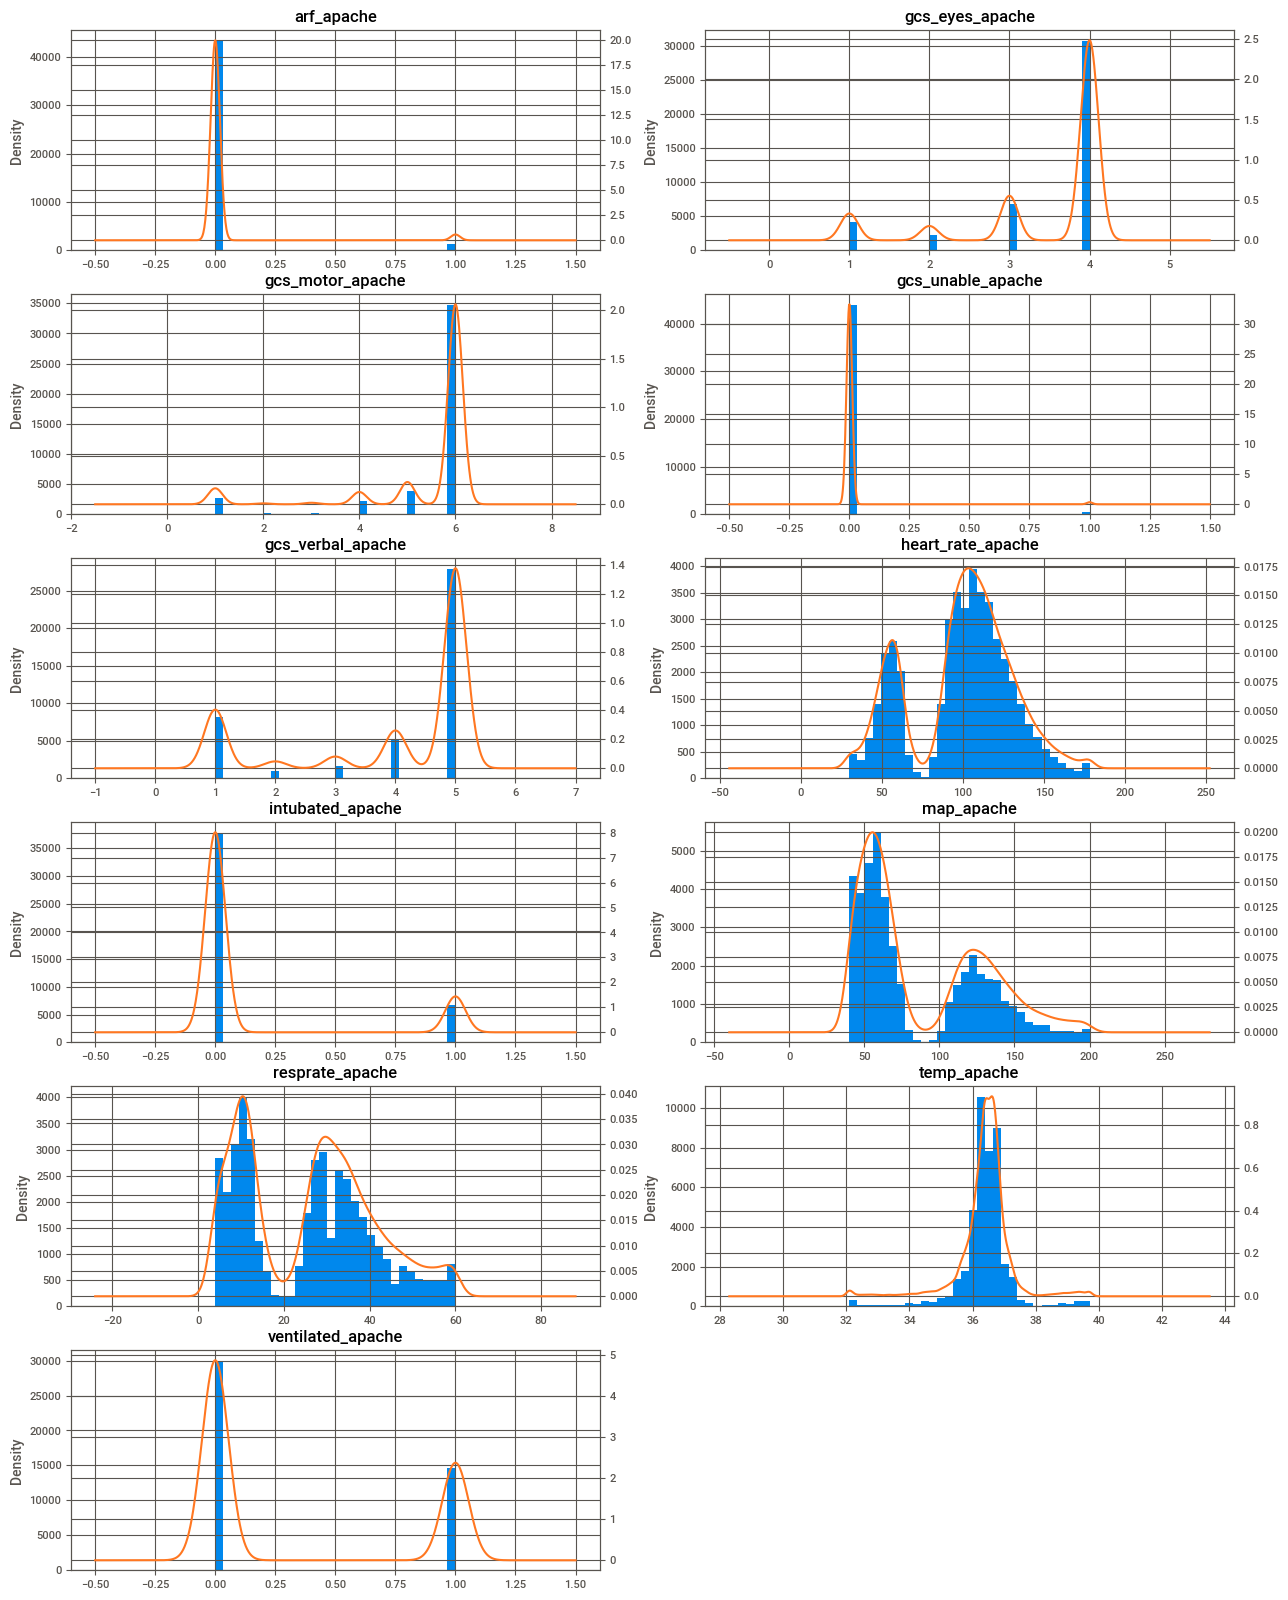

In [43]:
# 畫張圖看看
fig = plt.figure(figsize=(15,20))
figlen = len(_apache)
for idx,feature in enumerate(_apache):
    ax1 = fig.add_subplot(figlen//2+1,2,idx+1)
    plt.title(feature)
    df[feature].hist(bins=30, alpha=1, ax = ax1)
    df[feature].plot(kind='kde', secondary_y = True, ax = ax1)
    plt.grid()

cat_apache = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache']
num_apache = ['heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache']

## Final determination about column type

In [3]:
num_cols = [
    'd1_diasbp_max',
    'd1_diasbp_noninvasive_max',
    'd1_heartrate_max',
    'd1_mbp_max',
    'd1_mbp_noninvasive_max',
    'd1_resprate_max',
    'd1_spo2_max',
    'd1_sysbp_max',
    'd1_sysbp_noninvasive_max',
    'd1_temp_max',
    'h1_diasbp_max',
    'h1_diasbp_noninvasive_max',
    'h1_heartrate_max',
    'h1_mbp_max',
    'h1_mbp_noninvasive_max',
    'h1_resprate_max',
    'h1_spo2_max',
    'h1_sysbp_max',
    'h1_sysbp_noninvasive_max',
    'd1_glucose_max',
    'd1_potassium_max',
    'd1_diasbp_min',
    'd1_diasbp_noninvasive_min',
    'd1_heartrate_min',
    'd1_mbp_min',
    'd1_mbp_noninvasive_min',
    'd1_resprate_min',
    'd1_spo2_min',
    'd1_sysbp_min',
    'd1_sysbp_noninvasive_min',
    'd1_temp_min',
    'h1_diasbp_min',
    'h1_diasbp_noninvasive_min',
    'h1_heartrate_min',
    'h1_mbp_min',
    'h1_mbp_noninvasive_min',
    'h1_resprate_min',
    'h1_spo2_min',
    'h1_sysbp_min',
    'h1_sysbp_noninvasive_min',
    'd1_glucose_min',
    'd1_potassium_min',
    'pre_icu_los_days',
    'age',
    'bmi',
    'height',
    'weight',
    'heart_rate_apache',
    'map_apache',
    'resprate_apache',
    'temp_apache',
    'apache_4a_hospital_death_prob',
    'apache_4a_icu_death_prob'
]

cat_cols = [
    'ethnicity',
    'gender',
    'icu_admit_source',
    'icu_stay_type',
    'icu_type',
    'apache_3j_bodysystem',
    'apache_2_bodysystem',
    'aids',
    'arf_apache',
    'gcs_unable_apache',
    'intubated_apache',
    'ventilated_apache',
    'apache_2_diagnosis',
    'apache_3j_diagnosis',
    'apache_post_operative',
    'gcs_eyes_apache',
    'gcs_motor_apache',
    'gcs_verbal_apache',
    'hospital_id',
    'icu_id',
    'elective_surgery',
    'diabetes_mellitus',
    'hepatic_failure',
    'immunosuppression',
    'leukemia',
    'lymphoma',
    'solid_tumor_with_metastasis'
]

---
---

# Dimension reduction for visualization

In [52]:
# Preparing the data
df1 = df[num_cols + cat_cols + ['has_died']]
df1[num_cols] = df1[num_cols].fillna(df1[num_cols].mean())
df1[cat_cols] = df1[cat_cols].fillna('unknow')

X_for_viz = df1.drop(columns = 'has_died')
y_for_viz = df1['has_died']

encoder = ce.LeaveOneOutEncoder(cols=cat_cols) # 拿心率當 target
encoder.fit(X_for_viz, y_for_viz) # 拿 y 做 target

X_for_viz = encoder.transform(X_for_viz)

## TSNE & PCA

In [53]:
X_reduced_tsne = TSNE(n_components=2, random_state=2).fit_transform(X_for_viz)
X_reduced_pca = PCA(n_components=2, random_state=2).fit_transform(X_for_viz)

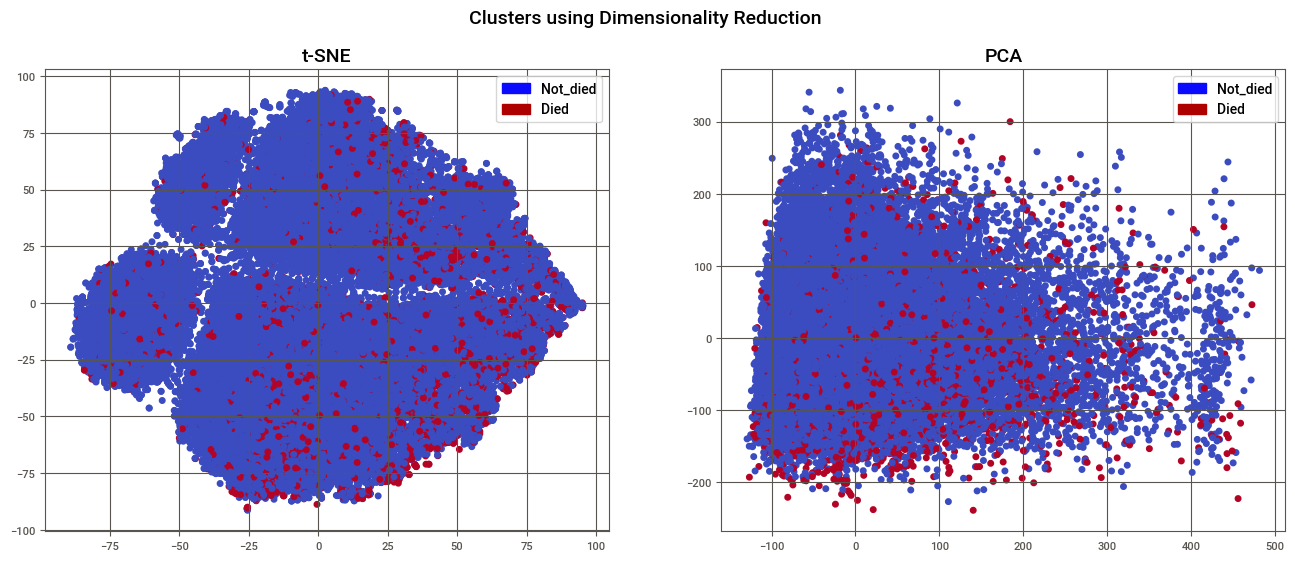

In [54]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Not_died')
red_patch = mpatches.Patch(color='#AF0000', label='Died')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y_for_viz, cmap='coolwarm', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y_for_viz, cmap='coolwarm', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

plt.show()

### Upsampling

In [55]:
scaler = MinMaxScaler()
bordsmoter = BorderlineSMOTE(random_state=5201314)

# 資料前處理: Normalization
X_for_viz_normalize = scaler.fit_transform(X_for_viz)

# 資料前處理: Oversampling
X_for_viz_oversample, y_for_viz_oversample = bordsmoter.fit_resample(X_for_viz_normalize, y_for_viz)

In [56]:
X_reduced_upsample_tsne = TSNE(n_components=2, random_state=2).fit_transform(X_for_viz_oversample)
X_reduced_upsample_pca = PCA(n_components=2, random_state=2).fit_transform(X_for_viz_oversample)

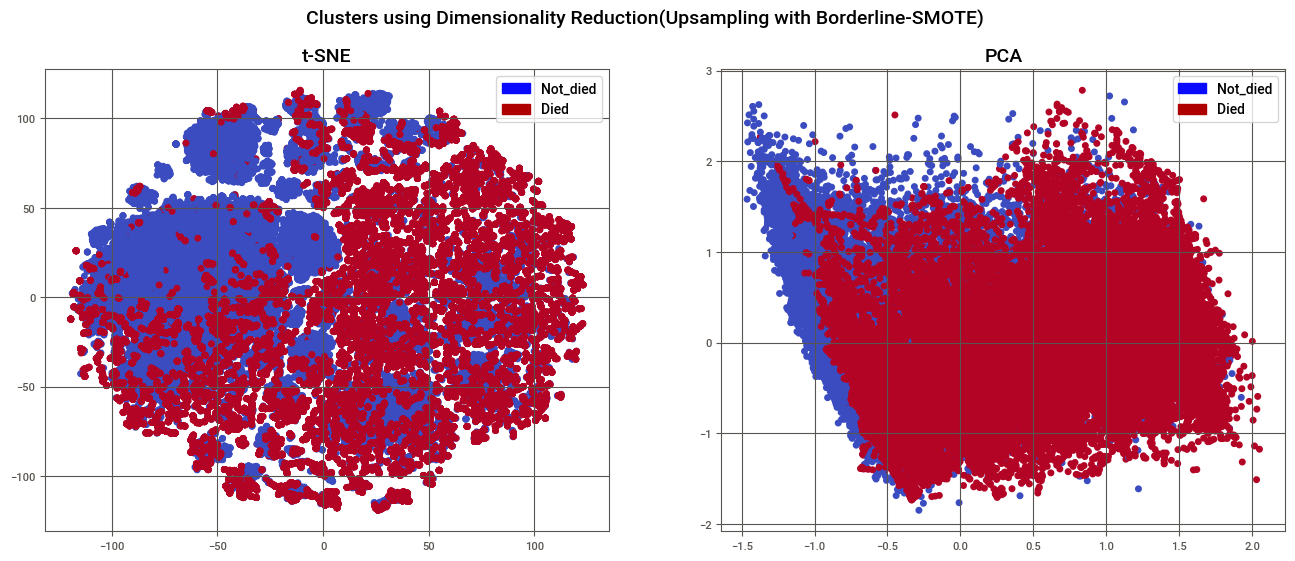

In [59]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Clusters using Dimensionality Reduction(Upsampling with Borderline-SMOTE)', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Not_died')
red_patch = mpatches.Patch(color='#AF0000', label='Died')

# t-SNE scatter plot
ax1.scatter(X_reduced_upsample_tsne[:, 0], X_reduced_upsample_tsne[:, 1], c=y_for_viz_oversample, cmap='coolwarm', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_upsample_pca[:, 0], X_reduced_upsample_pca[:, 1], c=y_for_viz_oversample, cmap='coolwarm', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

plt.show()

---
---

# Training
* 切分私有測試集 > 不依賴 kaggle 分數評估模型
* 在 score_model() 內手動實作 k-fold Cross Validation > 更好地預測 test 分數，並且用於後續調整超參數參考
* 使用 Optuna 調整超參後使用全訓練集 retrain model 後預測 Kaggle Public Test Dataset 後提交

### 切分私有測試集 X_test, y_test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5201314, stratify=y) # stratify=y 確保了分層抽樣

### 將三份 X 資料集過濾出欲採納之 feature 欄位

In [5]:
X_train = X_train[num_cols + cat_cols]
X_test  =  X_test[num_cols + cat_cols]
X_test_public = X_test_public[['patient_id'] + num_cols + cat_cols]
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_test_public shape:', X_test_public.shape) # 會多一個 patient_id 用於後續提交預測檔

X_train shape: (35951, 80)
X_test shape: (8988, 80)
X_test_public shape: (19260, 81)


### 實作 K-fold Cross Validation

In [7]:
def score_model(model, X, y, params=None, cv=None, max_iter=10):
    '''
    Input:
    (model) should be a model object(e.g. XGBClassifier(random_state=42))
    Output: 
    (scores) (AUROC_SCORES, f1_macro_scores)
    '''
    if cv is None:
        cv = StratifiedKFold(n_splits=5, random_state=5201314, shuffle=True)
    
    X_train = X
    y_train = y
    
    target_encoder = ce.LeaveOneOutEncoder(cols=cat_cols)
    scaler = MinMaxScaler()
    bordsmoter = BorderlineSMOTE(random_state=5201314)
    
    # =========================================================================================
    # 手做 K-fold Cross Validation

    AUROC_scores = []
    f1_macro_scores = []
    
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        X_val_fold,   y_val_fold   = X_train.iloc[val_fold_index],   y_train.iloc[val_fold_index]
        
        #資料前處理: Imputation
        X_train_fold[num_cols] = X_train_fold[num_cols].fillna(X_train_fold[num_cols].mean())
        X_train_fold[cat_cols] = X_train_fold[cat_cols].fillna('unknow')

        X_val_fold[num_cols] = X_val_fold[num_cols].fillna(X_train_fold[num_cols].mean()) # 注意裡面是用 training data 的統計資料
        X_val_fold[cat_cols] = X_val_fold[cat_cols].fillna('unknow')
        
        
        # 資料前處理: Target encoding
        target_encoder.fit(X_train_fold[cat_cols], y_train_fold)
        X_train_fold[cat_cols] = target_encoder.transform(X_train_fold[cat_cols])
        X_val_fold[cat_cols]   = target_encoder.transform(X_val_fold[cat_cols])
        
        # 資料前處理: Normalization
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        
        # 資料前處理: Oversampling
        X_train_fold_oversample, y_train_fold_oversample = bordsmoter.fit_resample(X_train_fold, y_train_fold)
        
        # 建立 model 實例
        if params is None:
            model_obj = model
        else:
            model_obj = model.set_params(**params)

        # Fit model
        model_obj.fit(X_train_fold_oversample, y_train_fold_oversample)
        
        # Predict and Evaluation
        y_val_pred = model_obj.predict(X_val_fold)
        y_val_proba = model_obj.predict_proba(X_val_fold)[:, 1]
        AUROC_scores.append(roc_auc_score(y_val_fold, y_val_proba))
        f1_macro_scores.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    # =========================================================================================    
    
    return np.array(AUROC_scores), np.array(f1_macro_scores)

### 訓練並獲取每層評分

In [10]:
# CV obj
sss = StratifiedKFold(n_splits=5, random_state=5201314, shuffle=True)

# model obj
LGB = lgb.LGBMClassifier(is_unbalance=False, n_jobs=-1, use_missing=False, verbosity=-1)

auroc, f1_macro = score_model(LGB, X=X_train, y=y_train, cv=sss)
print(f'   AUROC in each fold: {auroc}, average: {auroc.mean(): .5}')
print(f'F1_macro in each fold: {f1_macro}, average: {f1_macro.mean(): .5}')

   AUROC in each fold: [0.86371493 0.87165734 0.86825698 0.88402637 0.86726338], average:  0.87098
F1_macro in each fold: [0.69468358 0.70459722 0.7224211  0.7098041  0.70169701], average:  0.70664


### 以私有測試集評分

In [14]:
def retrain(X_train, y_train, X_test, y_test, model):
    target_encoder = ce.LeaveOneOutEncoder(cols=cat_cols)
    scaler = MinMaxScaler()
    bordsmoter = BorderlineSMOTE(random_state=5201314)

    # 所有私有切分之訓練集
    X_train_ = X_train
    y_train_ = y_train

    # 所有私有切分之測試集
    X_test_ = X_test
    y_test_ = y_test

    # 資料前處理: Imputation
    X_train_[num_cols] = X_train_[num_cols].fillna(X_train_[num_cols].mean())
    X_train_[cat_cols] = X_train_[cat_cols].fillna('unknow')
    X_test_[num_cols] = X_test_[num_cols].fillna(X_train_[num_cols].mean())
    X_test_[cat_cols] = X_test_[cat_cols].fillna('unknow')

    # 資料前處理: Target encoding
    target_encoder.fit(X_train_[cat_cols], y_train_)
    X_train_[cat_cols] = target_encoder.transform(X_train_[cat_cols])
    X_test_[cat_cols] = target_encoder.transform(X_test_[cat_cols])

    # 資料前處理: Normalization
    X_train_ = scaler.fit_transform(X_train_)
    X_test_ = scaler.transform(X_test_)

    # 資料前處理: Oversampling
    X_train_oversampling_, y_train_oversampling_ = bordsmoter.fit_resample(X_train_, y_train_)

    model.fit(X_train_oversampling_, y_train_oversampling_, feature_name=num_cols+cat_cols)

    # Predict
    y_test_predict_ = model.predict(X_test_)
    y_pred_proba_ = model.predict_proba(X_test_)[:, 1]

    print(f" F1_macro: {f1_score(y_test_, y_test_predict_, average='macro'):.4}")
    print(f"    AUROC: {roc_auc_score(y_test_, y_pred_proba_):.4}")
    print(f" Accuracy: {accuracy_score(y_test_, y_test_predict_):.4}")
    print(f"Precision: {precision_score(y_test_, y_test_predict_):.4}")
    print(f"   Recall: {recall_score(y_test_, y_test_predict_):.4}")

    return y_test_predict_, y_pred_proba_

y_test_predict_, y_pred_proba_ = retrain(X_train, y_train, X_test, y_test, model=LGB)



 F1_macro: 0.7303
    AUROC: 0.8885
 Accuracy: 0.9243
Precision: 0.5816
   Recall: 0.4407


### 以 Optuna 調整超參數

In [11]:
LGB = lgb.LGBMClassifier()

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 1.0),
        'is_unbalance':False, 
        'n_jobs':-1, 
        'use_missing':False, 
        'verbosity':-1
    }
    
    # 使用 5-fold 平均 f1_macro 調整超參數
    _, f1_macro_score = score_model(LGB, params=params, X=X_train, y=y_train, cv=sss)
    metric = f1_macro_score.mean()

    return metric

In [12]:
alg = optuna.samplers.TPESampler(seed=5201314)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(sampler=alg, pruner=pruner, direction='maximize')

study.optimize(objective,show_progress_bar=False, n_trials=600, n_jobs=-1)

# 運用 study.best_trial 獲取最佳試驗的資訊
best_trial = study.best_trial
print('\n\nSampler is {}'.format(study.sampler.__class__.__name__))
print('Pruner is {}'.format(study.pruner.__class__.__name__))
print('Best F1_macro={}\nHyperparameters = {}\n'.format(best_trial.value, best_trial.params))

[I 2023-12-22 19:35:42,843] A new study created in memory with name: no-name-7ccfa90c-7696-43a4-b20e-2a54ab9bbfa4
[I 2023-12-22 19:37:27,870] Trial 17 finished with value: 0.6620992059653569 and parameters: {'num_leaves': 115, 'learning_rate': 0.017824086307135317, 'feature_fraction': 0.39828931966524017, 'bagging_fraction': 0.8535072127725555, 'lambda_l1': 0.00027852733726235795, 'lambda_l2': 0.010795748624781987, 'min_child_samples': 62, 'max_depth': 4, 'min_child_weight': 0.007621214113625197}. Best is trial 17 with value: 0.6620992059653569.
[I 2023-12-22 19:37:32,208] Trial 6 finished with value: 0.6809580645100712 and parameters: {'num_leaves': 31, 'learning_rate': 0.017373233340169582, 'feature_fraction': 0.40906743487172914, 'bagging_fraction': 0.38600207289488986, 'lambda_l1': 3.9046221279836264e-07, 'lambda_l2': 5.947851948127974e-07, 'min_child_samples': 17, 'max_depth': 6, 'min_child_weight': 0.004908889135504513}. Best is trial 6 with value: 0.6809580645100712.
[I 2023-12-



Sampler is TPESampler
Pruner is HyperbandPruner
Best F1_macro=0.7129138145885008
Hyperparameters = {'num_leaves': 81, 'learning_rate': 0.03893893356404946, 'feature_fraction': 0.5897356413877914, 'bagging_fraction': 0.8231150428212237, 'lambda_l1': 0.0028906876087171733, 'lambda_l2': 7.338541892212375e-08, 'min_child_samples': 92, 'max_depth': 15, 'min_child_weight': 0.000126192962322796}



### 以私有測試集搭配最佳超參評分

In [15]:
best_params = study.best_params

LGB_best = lgb.LGBMClassifier(**best_params, is_unbalance=False, n_jobs=-1, use_missing=False, verbosity=-1)

y_test_predict_, y_pred_proba_ = retrain(X_train, y_train, X_test, y_test, model=LGB_best)

 F1_macro: 0.725
    AUROC: 0.8838
 Accuracy: 0.9194
Precision: 0.5398
   Recall: 0.4549


In [16]:
labels = ['Not Died', 'Is Died']
print(classification_report(y_test, y_test_predict_, target_names=labels))

              precision    recall  f1-score   support

    Not Died       0.95      0.96      0.96      8212
     Is Died       0.54      0.45      0.49       776

    accuracy                           0.92      8988
   macro avg       0.74      0.71      0.72      8988
weighted avg       0.91      0.92      0.92      8988



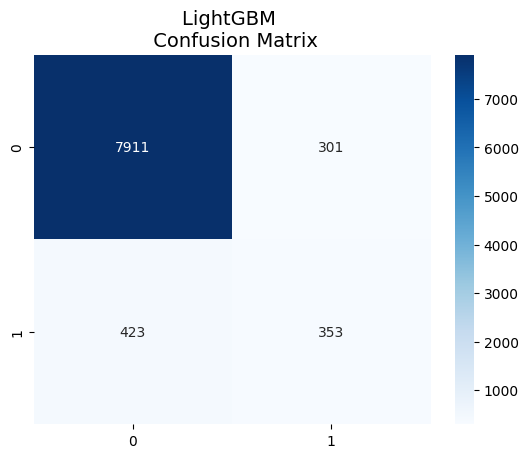

In [17]:
cf = confusion_matrix(y_test, y_test_predict_)

fig, ax = plt.subplots()

ax.set_title("LightGBM \n Confusion Matrix", fontsize=14)
sns.heatmap(cf, ax=ax, annot=True, cmap=plt.cm.Blues, fmt='d')

plt.show()

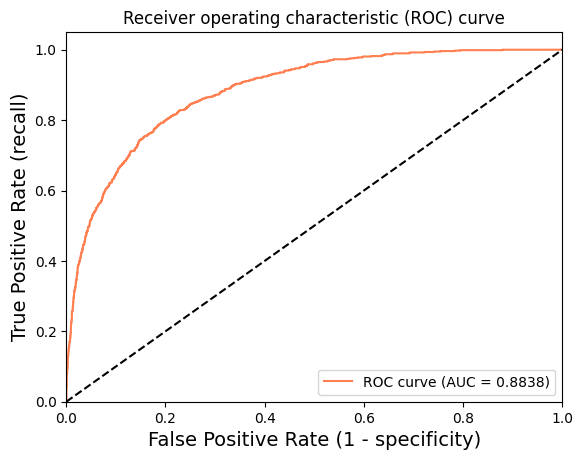

In [18]:
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba_)

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (AUC = %0.4f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

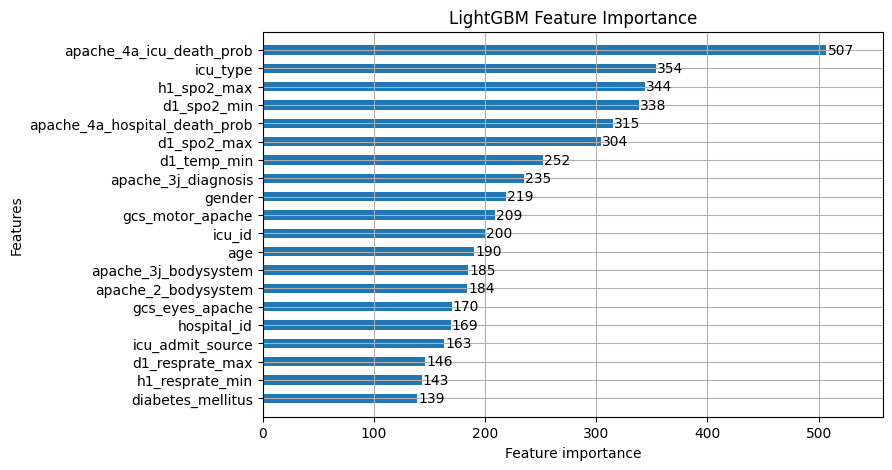

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
lgb.plot_importance(LGB_best, height=0.5, dpi=800, title="LightGBM Feature Importance",max_num_features=20, ax=ax)
plt.show()

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

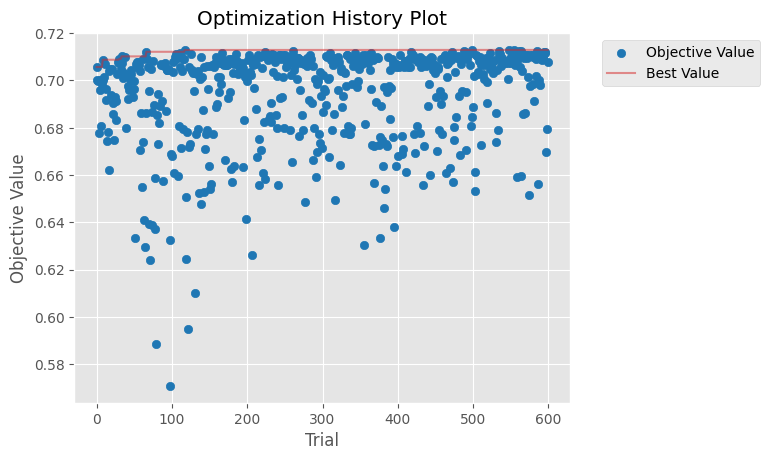

In [20]:
from optuna.visualization import matplotlib as optuna_matplotlib

# 繪製 Optimization History 圖
optuna_matplotlib.plot_optimization_history(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

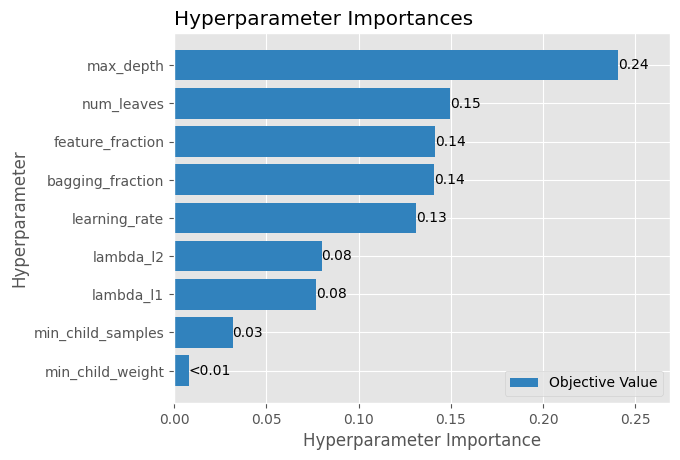

In [21]:
optuna_matplotlib.plot_param_importances(study)

array([<Axes: xlabel='bagging_fraction', ylabel='Objective Value'>,
       <Axes: xlabel='feature_fraction'>, <Axes: xlabel='lambda_l1'>,
       <Axes: xlabel='lambda_l2'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='max_depth'>, <Axes: xlabel='min_child_samples'>,
       <Axes: xlabel='min_child_weight'>, <Axes: xlabel='num_leaves'>],
      dtype=object)

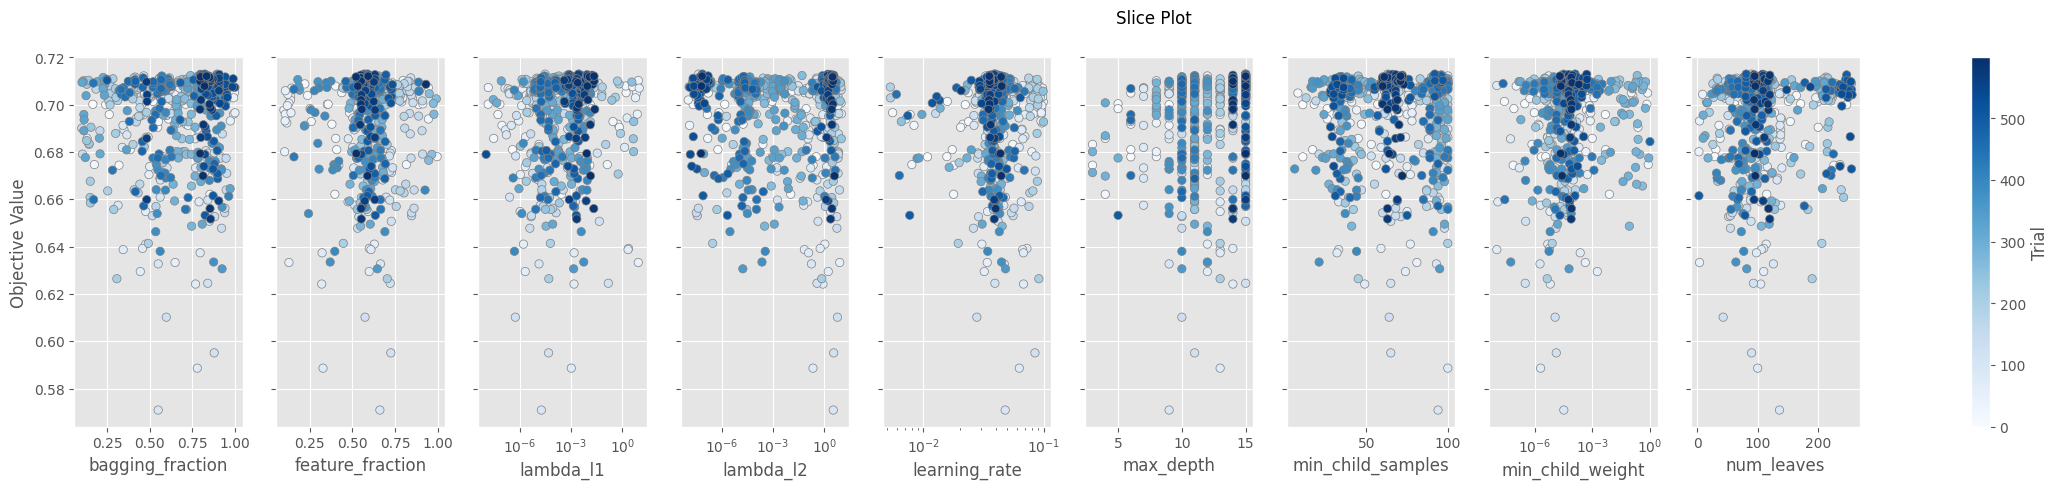

In [22]:
optuna_matplotlib.plot_slice(study)

---
---

# Predict

In [25]:
target_encoder = ce.LeaveOneOutEncoder(cols=cat_cols)
scaler = MinMaxScaler()
bordsmoter = BorderlineSMOTE(random_state=5201314)


X_train_ = X[num_cols + cat_cols] # 所有 X data
y_train_ = y # 所有 y data
X_test_ = X_test_public.iloc[:, 1:] # private 的 X 測試資料
patient_ids = X_test_public['patient_id']

# 資料前處理: Imputation
X_train_[num_cols] = X_train_[num_cols].fillna(X_train_[num_cols].mean())
X_train_[cat_cols] = X_train_[cat_cols].fillna('unknow')
X_test_[num_cols] = X_test_[num_cols].fillna(X_train_[num_cols].mean())
X_test_[cat_cols] = X_test_[cat_cols].fillna('unknow')

# 資料前處理: Target encoding
target_encoder.fit(X_train_[cat_cols], y_train_)
X_train_[cat_cols] = target_encoder.transform(X_train_[cat_cols])
X_test_[cat_cols] = target_encoder.transform(X_test_[cat_cols])

# 資料前處理: Normalization
X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

# 資料前處理: Oversampling
X_train_oversampling_, y_train_oversampling_ = bordsmoter.fit_resample(X_train_, y_train_)

# fit Model -> 以最佳超參數模型進行預測
LGB_best.fit(X_train_oversampling_, y_train_oversampling_)

# test_predict
private_test_predicts = LGB_best.predict(X_test_)
prediction_df = pd.DataFrame({'patient_id': patient_ids, 
                              'pred': private_test_predicts})


prediction_df.to_csv(r'prediction\LGB_BORDLINE_SMOTE_final.csv', index=False)
prediction_df.head() # show out

,patient_id,pred
0,326,0
1,43497,0
2,117587,0
3,22299,0
4,65485,0


---
---

# Save Best Model

In [27]:
import pickle

In [28]:
file = 'finetuned_LGBM_model.pkl'
pickle.dump(LGB_best, open(file, 'wb'))
print('Trained LGB model was saved!')

Trained LGB model was saved!


---
---
# Reproduce

In [30]:
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

from imblearn.over_sampling import BorderlineSMOTE
import pickle

In [31]:
num_cols = [
    'd1_diasbp_max',
    'd1_diasbp_noninvasive_max',
    'd1_heartrate_max',
    'd1_mbp_max',
    'd1_mbp_noninvasive_max',
    'd1_resprate_max',
    'd1_spo2_max',
    'd1_sysbp_max',
    'd1_sysbp_noninvasive_max',
    'd1_temp_max',
    'h1_diasbp_max',
    'h1_diasbp_noninvasive_max',
    'h1_heartrate_max',
    'h1_mbp_max',
    'h1_mbp_noninvasive_max',
    'h1_resprate_max',
    'h1_spo2_max',
    'h1_sysbp_max',
    'h1_sysbp_noninvasive_max',
    'd1_glucose_max',
    'd1_potassium_max',
    'd1_diasbp_min',
    'd1_diasbp_noninvasive_min',
    'd1_heartrate_min',
    'd1_mbp_min',
    'd1_mbp_noninvasive_min',
    'd1_resprate_min',
    'd1_spo2_min',
    'd1_sysbp_min',
    'd1_sysbp_noninvasive_min',
    'd1_temp_min',
    'h1_diasbp_min',
    'h1_diasbp_noninvasive_min',
    'h1_heartrate_min',
    'h1_mbp_min',
    'h1_mbp_noninvasive_min',
    'h1_resprate_min',
    'h1_spo2_min',
    'h1_sysbp_min',
    'h1_sysbp_noninvasive_min',
    'd1_glucose_min',
    'd1_potassium_min',
    'pre_icu_los_days',
    'age',
    'bmi',
    'height',
    'weight',
    'heart_rate_apache',
    'map_apache',
    'resprate_apache',
    'temp_apache',
    'apache_4a_hospital_death_prob',
    'apache_4a_icu_death_prob'
]

cat_cols = [
    'ethnicity',
    'gender',
    'icu_admit_source',
    'icu_stay_type',
    'icu_type',
    'apache_3j_bodysystem',
    'apache_2_bodysystem',
    'aids',
    'arf_apache',
    'gcs_unable_apache',
    'intubated_apache',
    'ventilated_apache',
    'apache_2_diagnosis',
    'apache_3j_diagnosis',
    'apache_post_operative',
    'gcs_eyes_apache',
    'gcs_motor_apache',
    'gcs_verbal_apache',
    'hospital_id',
    'icu_id',
    'elective_surgery',
    'diabetes_mellitus',
    'hepatic_failure',
    'immunosuppression',
    'leukemia',
    'lymphoma',
    'solid_tumor_with_metastasis'
]

In [35]:
# 設定正確資料路徑並讀入資料 dataset
X = pd.read_csv(r'train_X.csv')
y = pd.read_csv(r'train_y.csv')
X_test_public = pd.read_csv(r'test_X.csv')

target_encoder = ce.LeaveOneOutEncoder(cols=cat_cols)
scaler = MinMaxScaler()
bordsmoter = BorderlineSMOTE(random_state=5201314)

X_train_ = X[num_cols + cat_cols] # 所有 X data
y_train_ = y # 所有 y data
X_test_ = X_test_public[num_cols + cat_cols]
patient_ids = X_test_public['patient_id']

# 資料前處理: Imputation
X_train_[num_cols] = X_train_[num_cols].fillna(X_train_[num_cols].mean())
X_train_[cat_cols] = X_train_[cat_cols].fillna('unknow')
X_test_[num_cols] = X_test_[num_cols].fillna(X_train_[num_cols].mean())
X_test_[cat_cols] = X_test_[cat_cols].fillna('unknow')

# 資料前處理: Target encoding
target_encoder.fit(X_train_[cat_cols], y_train_)
X_train_[cat_cols] = target_encoder.transform(X_train_[cat_cols])
X_test_[cat_cols] = target_encoder.transform(X_test_[cat_cols])

# 資料前處理: Normalization
X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

# 資料前處理: Oversampling
X_train_oversampling_, y_train_oversampling_ = bordsmoter.fit_resample(X_train_, y_train_)

# 讀入模型: 確保路徑正確
pickled_model = pickle.load(open('model.pkl', 'rb'))

# test_predict
private_test_predicts = pickled_model.predict(X_test_)
prediction_df = pd.DataFrame({'patient_id': patient_ids, 
                              'pred': private_test_predicts})

# 確任寫出路徑並將 Reproduce 結果寫出
prediction_df.to_csv(r'prediction\reproduce.csv', index=False)
prediction_df.head() # show out

,patient_id,pred
0,326,0
1,43497,0
2,117587,0
3,22299,0
4,65485,0
